In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#libraries for NLP
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import HTML
!pip install chart_studio
!pip install textstat
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
!pip install -q tf-models-official
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
# import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 64 kB 609 kB/s eta 0:00:01
     |████████████████████████████████| 99 kB 949 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 3.4 MB/s eta 0:00:01


In [2]:
from tensorflow import keras

In [3]:
#lets import our dataset using pandas download from https://www.kaggle.com/c/nlp-getting-started/data
data = pd.read_csv('../input/nlp-getting-started/train.csv')

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
#from above we can see that keyword and location columns of our data are missing values.
data = data[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


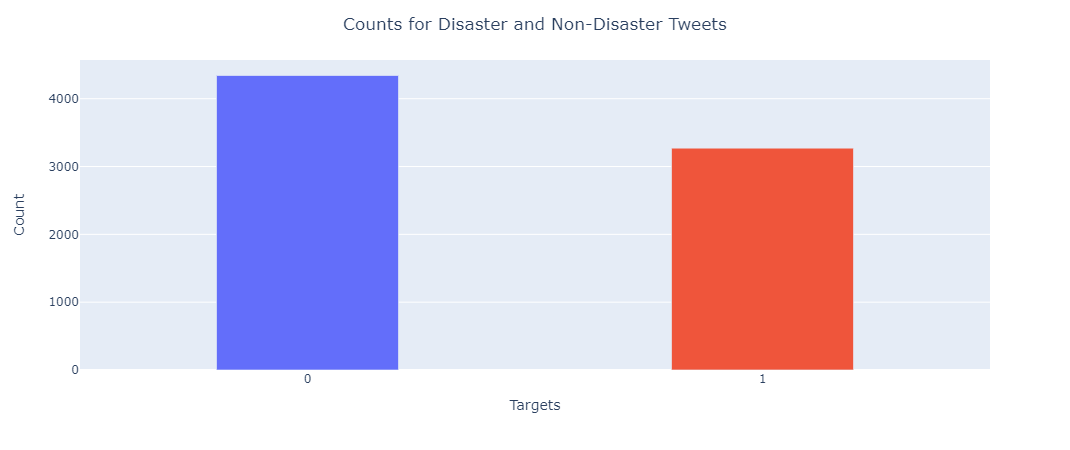

In [7]:
#from above we can see that keyword and location columns of our data are missing values.
#we visualize the counts of our target column
data = data[['text','target']]
fig = px.bar(x=["0","1"], y=data["target"].value_counts(),color=["red", "goldenrod"])
for dt in fig.data:
    dt["width"] = 0.4 #Change this value for bar widths
fig.update_layout(
    title_text = "Counts for Disaster and Non-Disaster Tweets",
    title_x=0.5,
    xaxis_title="Targets",
    yaxis_title="Count",
    showlegend=False
).show()

# py.plot(fig,filename='Counts for Disaster and Non-Disaster Tweets',auto_open=False,show_link=False)


<div>
    <a href="https://plotly.com/~raklugrin01/1/?share_key=hgjA8Zkl35RjZtywNHe0jm" target="_blank" title="Counts for Disaster and Non-Disaster Tweets" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/1.png?share_key=hgjA8Zkl35RjZtywNHe0jm" alt="Counts for Disaster and Non-Disaster Tweets" style="max-width: 100%;width: 1000px;"  width="1000" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:1" sharekey-plotly="hgjA8Zkl35RjZtywNHe0jm" src="https://plotly.com/embed.js" async></script>
</div>

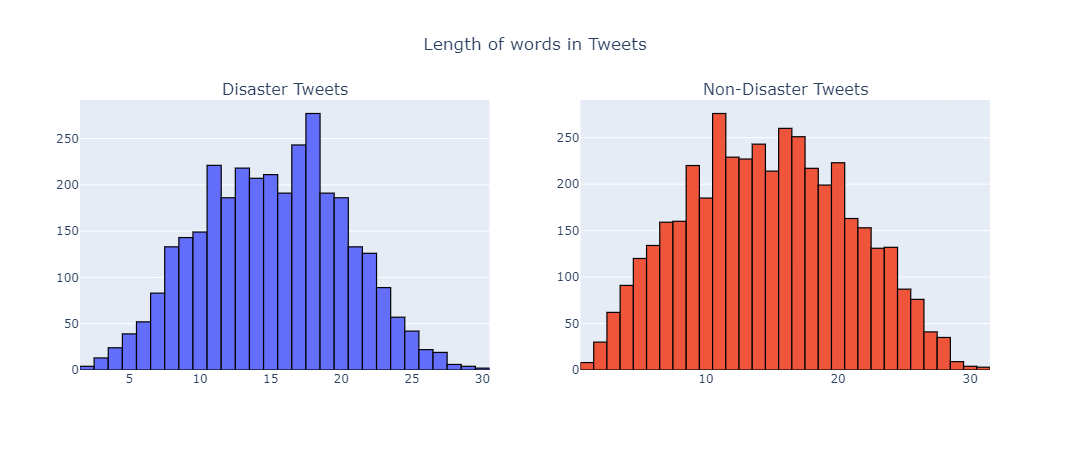

In [8]:
from plotly.subplots import make_subplots
#we see that our data is quite balanced 
#analyzing length of words in a tweet according to its target value
word_len_dis = data[data['target']==1]['text'].str.split().map(lambda x : len(x))
word_len_non_dis = data[data['target']==0]['text'].str.split().map(lambda x : len(x))
fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
    go.Histogram(x=word_len_dis,marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=1
).add_trace(
    go.Histogram(x=word_len_non_dis,marker_line=dict(color='black'),marker_line_width=1.2),
    row=1, col=2
).update_layout(title_text="Length of words in Tweets",title_x=0.5,showlegend=False).show()
# py.plot(fig,filename='Length of words in Tweets',auto_open=False,show_link=False)

<div>
    <a href="https://plotly.com/~raklugrin01/3/?share_key=c65IIAyuBQBfgU1Rfovdfb" target="_blank" title="Length of words in Tweets" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/3.png?share_key=c65IIAyuBQBfgU1Rfovdfb" alt="Length of words in Tweets" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:3" sharekey-plotly="c65IIAyuBQBfgU1Rfovdfb" src="https://plotly.com/embed.js" async></script>
</div>


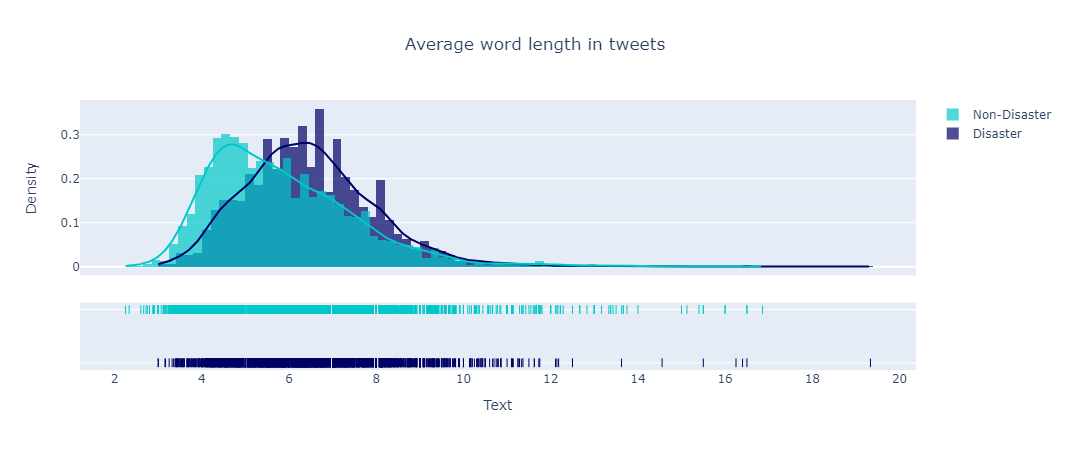

In [9]:
#from above we can see that number of words in the tweets ranges from 2 to 30
import plotly.figure_factory as ff
#now we will check average word length for both type of tweets
def avgwordlen(strlist):
    sum=[]
    for i in strlist:
        sum.append(len(i))
    return sum
avgword_len_dis = data[data['target']==1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))
avgword_len_non_dis = data[data['target']==0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))
group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], group_labels, bin_size=.2, colors=colors,)
fig.update_layout(title_text="Average word length in tweets",title_x=0.5,xaxis_title="Text",yaxis_title="Density").show()
# py.plot(fig,filename='Average word length in tweets',auto_open=False,show_link=False)

<div>
    <a href="https://plotly.com/~raklugrin01/5/?share_key=tfNQPMyUblqOh7JL1sEiqW" target="_blank" title="Average word length in tweets" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/5.png?share_key=tfNQPMyUblqOh7JL1sEiqW" alt="Average word length in tweets" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:5" sharekey-plotly="tfNQPMyUblqOh7JL1sEiqW" src="https://plotly.com/embed.js" async></script>
</div>


In [10]:
#it can be observed that the average word count for disaster tweets are found to be in the range(5-7.5)
# while for non-disaster tweets are in the range of (4-6).
# Creating sample corpus for further analysis.
def create_corpus(target):
    corpus = []
    for i in data[data['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

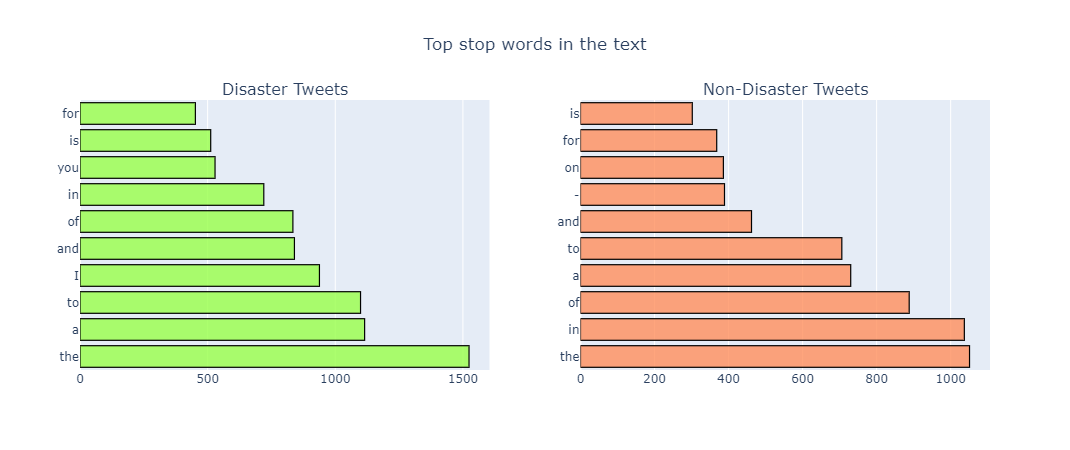

In [11]:
# Analysing top stop words in text.
from collections import defaultdict
values_list = []
def analyze_stopwords(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        dic[word] += 1
    
    top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
    x_items,y_values = zip(*top)
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing stopwords for 0 and 1 target labels
analyze_stopwords(data,create_corpus,[0,1])
fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
fig.add_trace(
  go.Bar(x=values_list[1],y=values_list[0],orientation='h',marker=dict(color= 'rgba(152, 255, 74,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=1, col=1
).add_trace(
  go.Bar(x=values_list[3],y=values_list[2],orientation='h',marker=dict(color= 'rgba(255, 143, 92,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=1, col=2
).update_layout(title_text="Top stop words in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top stop words in the text',auto_open=False,show_link=False)

<div>
    <a href="https://plotly.com/~raklugrin01/13/?share_key=icoxxtajqMGbKIizrTLUX0" target="_blank" title="Top stop words in the text" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/13.png?share_key=icoxxtajqMGbKIizrTLUX0" alt="Top stop words in the text" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:13" sharekey-plotly="icoxxtajqMGbKIizrTLUX0" src="https://plotly.com/embed.js" async></script>
</div>

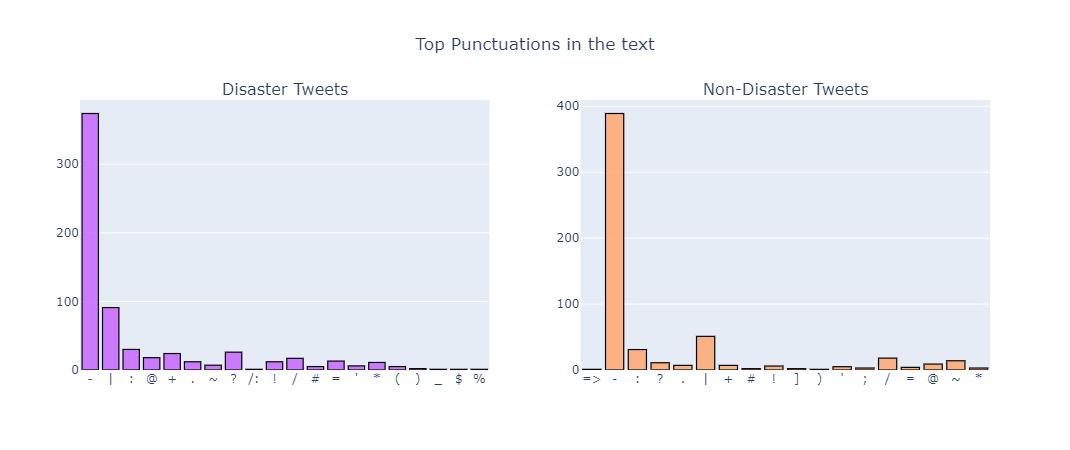

In [12]:
#The above Bar Charts displays the top 10 stop words in tweets where the occurs the most in both groups
# Anaysing Punctuations
from string import punctuation
values_list = []
def analyze_punctuations(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        if word in punctuation:
            dic[word] += 1 
    x_items, y_values = zip(*dic.items())
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing punctuations for 0 and 1 target labels
analyze_punctuations(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
  
fig.add_trace(
  go.Bar(x=values_list[0],y=values_list[1],marker=dict(color= 'rgba(196, 94, 255,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=1, col=1
).add_trace(
  go.Bar(x=values_list[2],y=values_list[3],marker=dict(color= 'rgba(255, 163, 102,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=1, col=2
).update_layout(title_text="Top Punctuations in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top Punctuations in the text',auto_open=False,show_link=False)

<div>
    <a href="https://plotly.com/~raklugrin01/15/?share_key=9JgPThmm677jJmNjJTc0BZ" target="_blank" title="Top Punctuations in the text" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/15.png?share_key=9JgPThmm677jJmNjJTc0BZ" alt="Top Punctuations in the text" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:15" sharekey-plotly="9JgPThmm677jJmNjJTc0BZ" src="https://plotly.com/embed.js" async></script>
</div>


In [13]:
#  it is observed that the most occuring punctuations in both disaster/non-disaster tweets is '-'(350+) and '|'
#  while the least occuring for non-disaster are '%','/:','$','_' and for disaster tweets is '=>', ')'.
# Now let's clean the data
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_data(data):

    review =re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) #removal of url
    review =re.sub(r'<.*?>',' ',review) #removal of html tags
    # Match all digits in the string and replace them by empty string
    review = re.sub(r'[0-9]', '', review)
    review = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',review)
    
    review = re.sub('[^a-zA-Z]',' ',review) # filtering out miscellaneous text.
    review = re.sub(r"\([^()]*\)", "", review)
    review = re.sub('@\S+', '', review)  # remove mentions
    review = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', review)  # remove punctuations
    review = review.lower() # Lowering all the words in text
    review = review.split()
    review = [lemmatizer.lemmatize(words) for words in review if words not in stopwords.words('english')]
    review = [i for i in review if len(i)>2] # Removal of words with length<2
    review = ' '.join(review)
    return review

data["Cleaned_text"] = data["text"].apply(preprocess_data)

In [14]:
# # !pip install pyspellchecker
# from spellchecker import SpellChecker
# from tqdm import tqdm
# spell = SpellChecker()
# def correct_spell(text):
#     corrected_text = []
#     mispelled_words = spell.unknown(text.split())
#     for word in tqdm(text.split()):
#         if word in mispelled_words:
#             corrected_text.append(spell.correction(text))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

# data["Cleaned_text"] = data["Cleaned_text"].apply(lambda x: correct_spell(x))

In [15]:
data.head()

,text,target,Cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [16]:
def wordcloud(data,title):
    words = ' '.join(data['Cleaned_text'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()
    

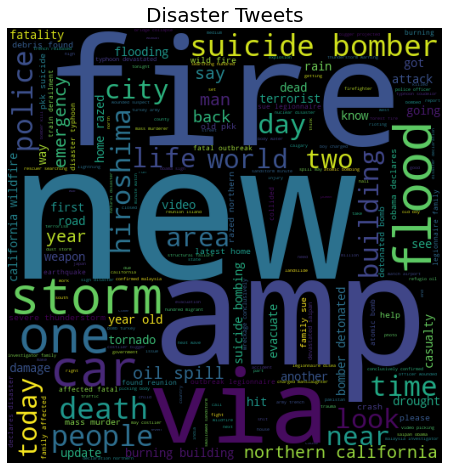

In [17]:
data_disaster = data[data['target'] == 1]
data_non_disaster = data[data['target'] == 0]

wordcloud(data_disaster,"Disaster Tweets")

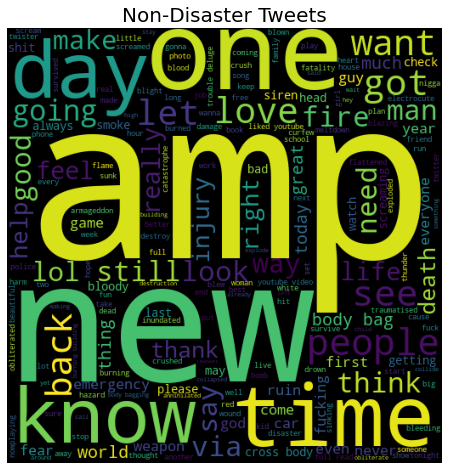

In [18]:
#we can see that most common words in disaster tweets are fire,storm,flood , police etc.
#now let's have a look on Non-Disaster tweets
wordcloud(data_non_disaster,"Non-Disaster Tweets")

In [19]:
#love,new,time etc are the most common words in wordcloud of Non-disaster tweets
#it appears that our cleaned text still contains some unnecessary words (such as: like, amp, get, would etc.) that aren't relevant and can confuse our model,
# resulting in false prediction.
# Now, we will further remove some confusing words from text based on above charts.

common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["Cleaned_text"] = data["Cleaned_text"].apply(text_cleaning)

In [20]:
# Now we will convert our cleaned text in numerical form as our model will only take numerical inputs
# BOW
def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True) 
    return word_freq[:n]

In [21]:
#analysing top 10 N-grams
common_uni = top_ngrams(data["Cleaned_text"],10,1)
common_bi = top_ngrams(data["Cleaned_text"],10,2)
common_tri = top_ngrams(data["Cleaned_text"],10,3)
common_uni_df = pd.DataFrame(common_uni,columns=['word','freq'])
common_bi_df = pd.DataFrame(common_bi,columns=['word','freq'])
common_tri_df = pd.DataFrame(common_tri,columns=['word','freq'])

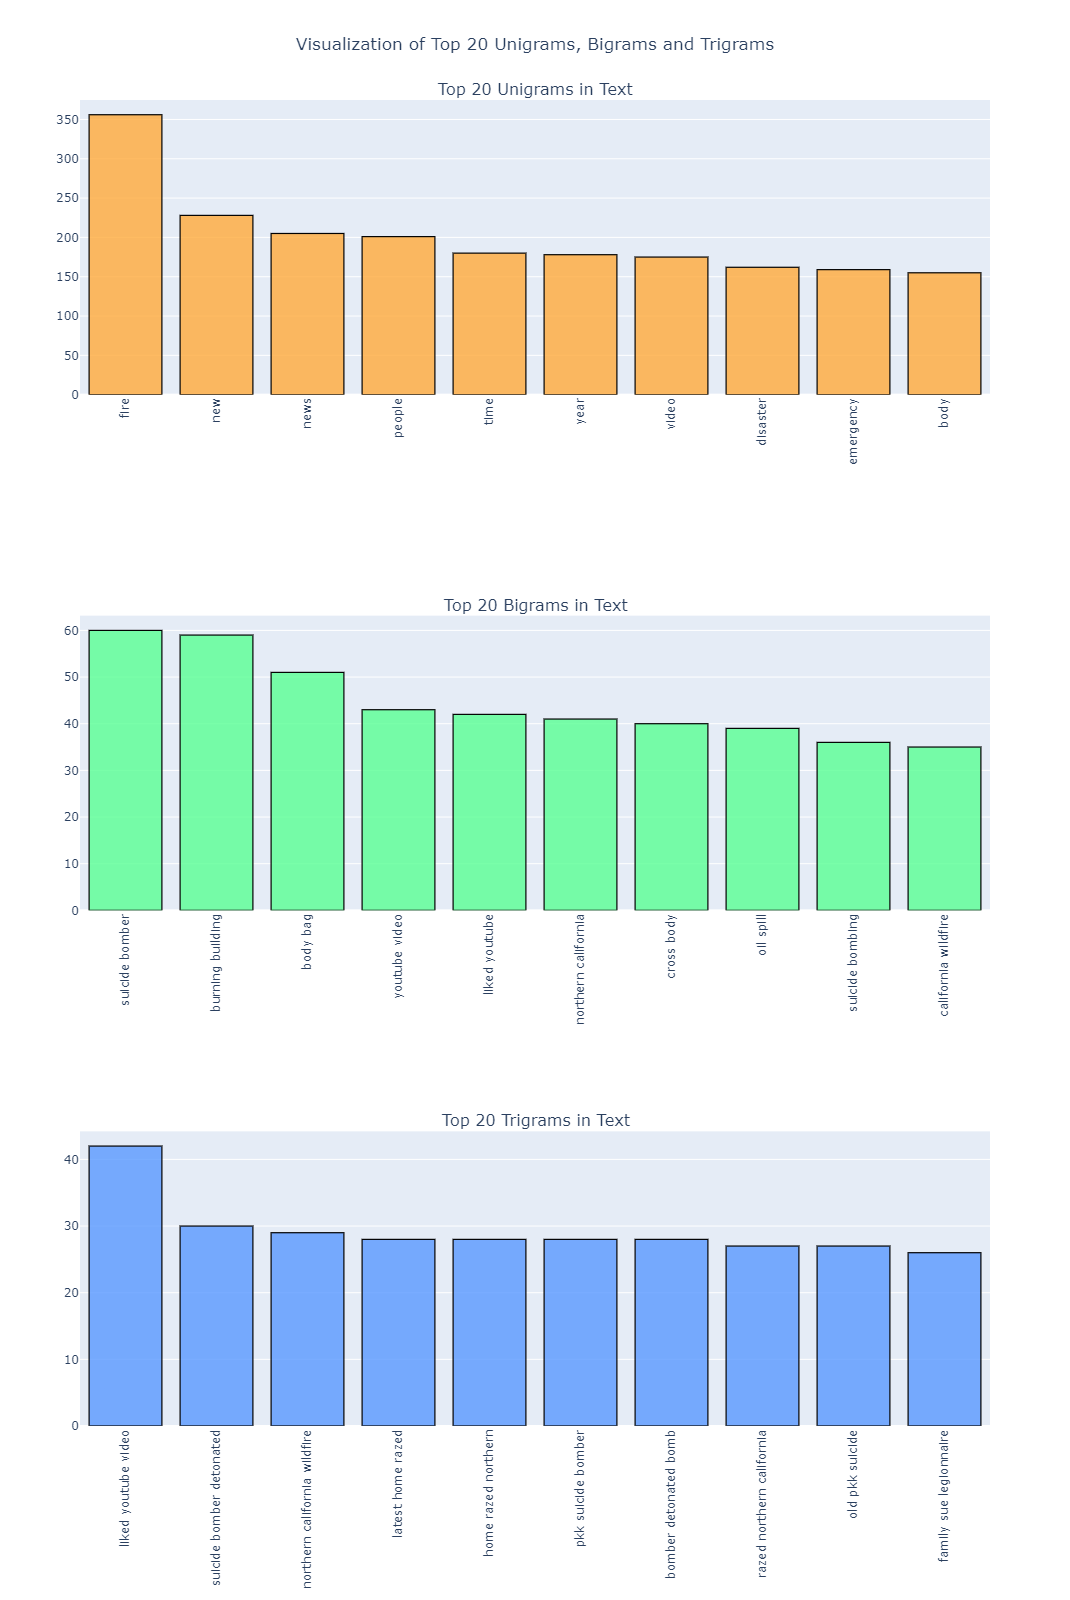

In [22]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Top 20 Unigrams in Text", "Top 20 Bigrams in Text","Top 20 Trigrams in Text"))
  
fig.add_trace(
  go.Bar(x=common_uni_df["word"],y=common_uni_df["freq"],marker=dict(color= 'rgba(255, 170, 59,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=1, col=1
).add_trace(
  go.Bar(x=common_bi_df["word"],y=common_bi_df["freq"],marker=dict(color= 'rgba(89, 255, 147,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=2, col=1
).add_trace(
  go.Bar(x=common_tri_df["word"],y=common_tri_df["freq"],marker=dict(color= 'rgba(89, 153, 255,0.8)'),marker_line=dict(color='black'),marker_line_width=1.2),
  row=3, col=1
).update_layout(title_text="Visualization of Top 20 Unigrams, Bigrams and Trigrams",title_x=0.5,showlegend=False,width=1400,height=1600,).update_xaxes(tickangle=-90).show()

# py.plot(fig,filename='Visualization of Top 20 Unigrams, Bigrams and Trigrams',auto_open=False,show_link=False)

<div>
    <a href="https://plotly.com/~raklugrin01/17/?share_key=rHBUmASeWITErHR7rEdZqJ" target="_blank" title="Visualization of Top 20 Unigrams, Bigrams and Trigrams" style="display: block; text-align: center;"><img src="https://plotly.com/~raklugrin01/17.png?share_key=rHBUmASeWITErHR7rEdZqJ" alt="Visualization of Top 20 Unigrams, Bigrams and Trigrams" style="max-width: 100%;width: 1400px;"  width="1400" onerror="this.onerror=null;this.src='https://plotly.com/404.png';" /></a>
    <script data-plotly="raklugrin01:17" sharekey-plotly="rHBUmASeWITErHR7rEdZqJ" src="https://plotly.com/embed.js" async></script>
</div>


In [23]:
#original data after cleaning |
X_inp_clean = data['Cleaned_text']
X_inp_original = data['text']
y_inp = data['target']

In [24]:
# Dividing the data into training and validation 
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_inp_clean, y_inp, test_size=0.2, random_state=42, stratify=y_inp)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [25]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6090,), (1523,), (6090,), (1523,))

In [26]:
#textpreprocessing
def encoding(train_data,valid_data,bow=False,n=1,tf_idf=False):
    if bow==True:
        cv = CountVectorizer(ngram_range=(n,n))
        cv_df_train = cv.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(cv_df_train,columns=cv.get_feature_names())
        cv_df_valid = cv.transform(valid_data).toarray()
        valid_df = pd.DataFrame(cv_df_valid,columns=cv.get_feature_names())
        
    elif tf_idf==True:
        
        tfidf = TfidfVectorizer(ngram_range=(n, n), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names())
        tf_df_valid = tfidf.transform(valid_data).toarray()
        valid_df = pd.DataFrame(tf_df_valid,columns=tfidf.get_feature_names())
        
    return train_df,valid_df

X_train_bow1 , X_valid_bow1 = encoding(X_train,X_valid,bow=True) 
X_train_bow2 , X_valid_bow2 = encoding(X_train,X_valid,bow=True,n=2) 
X_train_bow3 , X_valid_bow3 = encoding(X_train,X_valid,bow=True,n=3) 
X_train_tfidf1 , X_valid_tfidf1 = encoding(X_train,X_valid,tf_idf=True) 
X_train_tfidf2 , X_valid_tfidf2 = encoding(X_train,X_valid,tf_idf=True,n=2) 
X_train_tfidf3 , X_valid_tfidf3 = encoding(X_train,X_valid,tf_idf=True,n=3) 

In [27]:
X_valid_bow2.shape

(1523, 34323)

In [28]:
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU,MaxPooling1D,Conv1D
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [29]:
def c_report(y_true,y_pred):
    print("Classifictaion Report")
    print(classification_report(y_true, y_pred))
    acc_scr = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_scr))
    return acc_scr

def plot_cm(y_true,y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot = True, fmt='d', linewidth=0.5,
               cmap="Blues", cbar = False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

LogisticRegression()

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       869
           1       0.80      0.73      0.76       654

    accuracy                           0.81      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.81      0.81      0.80      1523

Accuracy : 0.8056467498358503


0.8056467498358503

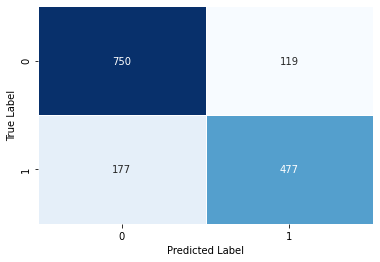

In [30]:
model_bow1_logreg = LogisticRegression(C=1.0)
model_bow1_logreg.fit(X_train_bow1,y_train)
pred_bow1_logreg = model_bow1_logreg.predict(X_valid_bow1)
c_report(y_valid,pred_bow1_logreg)
plot_cm(y_valid,pred_bow1_logreg)

LogisticRegression()

Classifictaion Report
              precision    recall  f1-score   support

           0       0.70      0.95      0.81       869
           1       0.87      0.46      0.60       654

    accuracy                           0.74      1523
   macro avg       0.79      0.70      0.70      1523
weighted avg       0.77      0.74      0.72      1523

Accuracy : 0.7386736703873933


0.7386736703873933

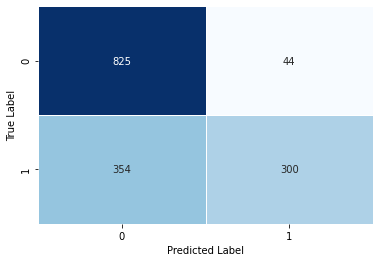

In [31]:
model_bow2_logreg = LogisticRegression(C=1.0)
model_bow2_logreg.fit(X_train_bow2,y_train)
pred_bow2_logreg = model_bow2_logreg.predict(X_valid_bow2)
c_report(y_valid,pred_bow2_logreg)
plot_cm(y_valid,pred_bow2_logreg)

LogisticRegression()

Classifictaion Report
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       869
           1       0.92      0.33      0.48       654

    accuracy                           0.70      1523
   macro avg       0.79      0.65      0.64      1523
weighted avg       0.77      0.70      0.66      1523

Accuracy : 0.6999343401181878


0.6999343401181878

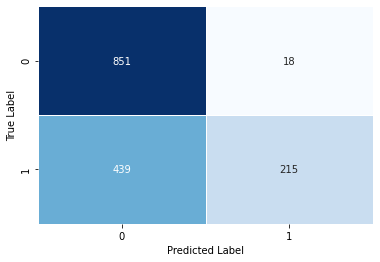

In [32]:
model_bow3_logreg = LogisticRegression(C=1.0)
model_bow3_logreg.fit(X_train_bow3,y_train)
pred_bow3_logreg = model_bow3_logreg.predict(X_valid_bow3)
c_report(y_valid,pred_bow3_logreg)
plot_cm(y_valid,pred_bow3_logreg)

In [33]:
#above results show us that using n = 1 will always give us more accuray
#now lets see Bag of words vs tfidf 

LogisticRegression()

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Accuracy : 0.8214051214707814


0.8214051214707814

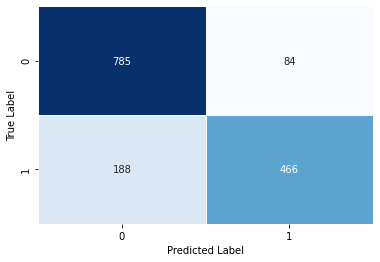

In [34]:
model_tfidf1_logreg = LogisticRegression(C=1.0)
model_tfidf1_logreg.fit(X_train_tfidf1,y_train)
pred_tfidf1_logreg = model_tfidf1_logreg.predict(X_valid_tfidf1)
c_report(y_valid,pred_tfidf1_logreg)
plot_cm(y_valid,pred_tfidf1_logreg)

MultinomialNB(alpha=0.7)

Classifictaion Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       869
           1       0.79      0.76      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523

Accuracy : 0.8122127380170716


0.8122127380170716

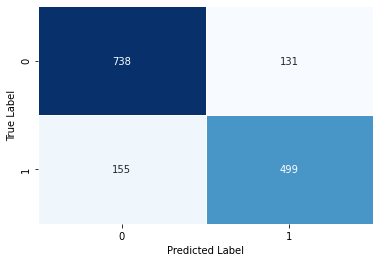

In [35]:
# tensorflow text preprocessing was surprisingly very poor for logisticRegression
model_bow1_NB = MultinomialNB(alpha=0.7)
model_bow1_NB.fit(X_train_bow1,y_train)
pred_bow1_NB = model_bow1_NB.predict(X_valid_bow1)
c_report(y_valid,pred_bow1_NB)
plot_cm(y_valid,pred_bow1_NB)

MultinomialNB(alpha=0.7)

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       869
           1       0.83      0.72      0.77       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.81      0.81      1523

Accuracy : 0.81483913328956


0.81483913328956

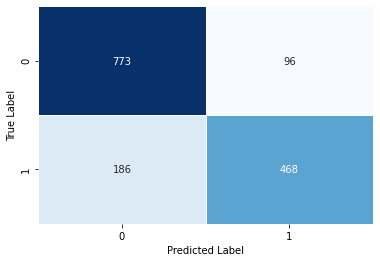

In [36]:
model_tfidf1_NB = MultinomialNB(alpha=0.7)
model_tfidf1_NB.fit(X_train_tfidf1,y_train)
pred_tfidf1_NB = model_tfidf1_NB.predict(X_valid_tfidf1)
c_report(y_valid,pred_tfidf1_NB)
plot_cm(y_valid,pred_tfidf1_NB)

RandomForestClassifier()

Classifictaion Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.70      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy : 0.7997373604727511


0.7997373604727511

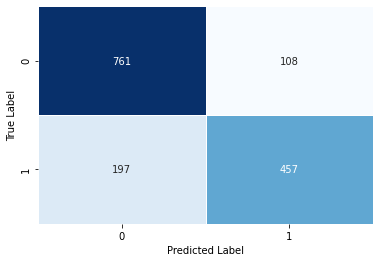

In [37]:
model_tfidf1_RFC = RandomForestClassifier()
model_tfidf1_RFC.fit(X_train_tfidf1,y_train)
pred_tfidf1_RFC = model_tfidf1_RFC.predict(X_valid_tfidf1)
c_report(y_valid,pred_tfidf1_RFC)
plot_cm(y_valid,pred_tfidf1_RFC)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Classifictaion Report
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       869
           1       0.82      0.67      0.73       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Accuracy : 0.7918581746552856


0.7918581746552856

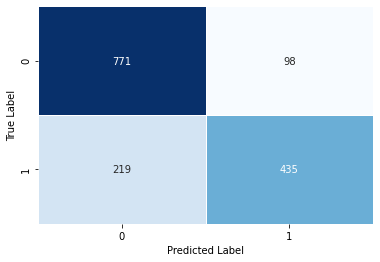

In [38]:
#we can see as the models are getting complex wem(tf) is giving us higher accuracy 
#but tfidf gives us almost the same and low
model_tfidf1_XGB = XGBClassifier(eval_metric='mlogloss')
model_tfidf1_XGB.fit(X_train_tfidf1,y_train)
pred_tfidf1_XGB = model_tfidf1_XGB.predict(X_valid_tfidf1)
c_report(y_valid,pred_tfidf1_XGB)
plot_cm(y_valid,pred_tfidf1_XGB)

Learning rate set to 0.184063
0:	learn: 0.6751641	total: 131ms	remaining: 13s
1:	learn: 0.6612089	total: 194ms	remaining: 9.5s
2:	learn: 0.6516296	total: 256ms	remaining: 8.27s
3:	learn: 0.6402127	total: 318ms	remaining: 7.63s
4:	learn: 0.6341778	total: 382ms	remaining: 7.26s
5:	learn: 0.6303885	total: 444ms	remaining: 6.96s
6:	learn: 0.6250751	total: 506ms	remaining: 6.72s
7:	learn: 0.6201513	total: 568ms	remaining: 6.53s
8:	learn: 0.6162209	total: 633ms	remaining: 6.4s
9:	learn: 0.6130236	total: 697ms	remaining: 6.27s
10:	learn: 0.6090610	total: 762ms	remaining: 6.16s
11:	learn: 0.6048562	total: 853ms	remaining: 6.26s
12:	learn: 0.6017630	total: 958ms	remaining: 6.41s
13:	learn: 0.5980340	total: 1.11s	remaining: 6.81s
14:	learn: 0.5939393	total: 1.27s	remaining: 7.18s
15:	learn: 0.5907048	total: 1.42s	remaining: 7.45s
16:	learn: 0.5861869	total: 1.57s	remaining: 7.68s
17:	learn: 0.5833033	total: 1.76s	remaining: 8s
18:	learn: 0.5806043	total: 1.92s	remaining: 8.18s
19:	learn: 0.57741

Classifictaion Report
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       869
           1       0.81      0.65      0.72       654

    accuracy                           0.78      1523
   macro avg       0.79      0.77      0.77      1523
weighted avg       0.79      0.78      0.78      1523

Accuracy : 0.7839789888378201


0.7839789888378201

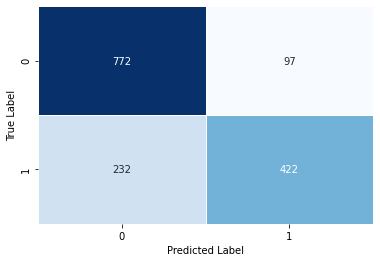

In [39]:
model_tfidf1_CBC = CatBoostClassifier(iterations=100)
model_tfidf1_CBC.fit(X_train_tfidf1,y_train)
pred_tfidf1_CBC = model_tfidf1_CBC.predict(X_valid_tfidf1)
c_report(y_valid,pred_tfidf1_CBC)
plot_cm(y_valid,pred_tfidf1_CBC)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('NB', MultinomialNB(alpha=0.7)),
                             ('XBG',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            eval_metric='mlogloss', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                 

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       869
           1       0.85      0.72      0.78       654

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523

Accuracy : 0.8266579120157583


0.8266579120157583

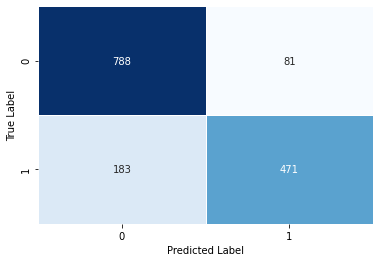

In [40]:
from sklearn.ensemble import VotingClassifier

estimators = []
estimators.append(('LR', 
                  LogisticRegression(C=1.0)))
estimators.append(('NB', MultinomialNB(alpha=0.7)))
estimators.append(('XBG', XGBClassifier(eval_metric='mlogloss')))

model_tfidf1_VC = VotingClassifier(estimators=estimators,voting='soft')
model_tfidf1_VC.fit(X_train_tfidf1,y_train)
pred_tfidf1_VC = model_tfidf1_VC.predict(X_valid_tfidf1)

c_report(y_valid,pred_tfidf1_VC)
plot_cm(y_valid,pred_tfidf1_VC)

In [41]:
acc_1 = 0.80565
acc_2 = 0.73867
acc_3 = 0.69993
acc_4 = 0.82141
acc_5 = 0.81221
acc_6 = 0.79514
acc_7 = 0.79186
acc_8 = 0.78398
acc_9 = 0.82666
results = pd.DataFrame([["Logistic Regression BoW1",acc_1],["Logistic Regression BoW2",acc_2],
                       ["Logistic Regression BoW3",acc_3],["Logistic Regression Tf-Idf1",acc_4],
                       ["Naive Bayes Tf-Idf1",acc_5],["Random Forest Tf-Idf1",acc_6],
                       ["XGBClassifier Tf-Idf1",acc_7],["CatBoost Tf-Idf1",acc_8],["Voting Tf-Idf1",acc_9]],
                       columns = ["Models","Accuracy Score"]).sort_values(by='Accuracy Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Models,Accuracy Score
8,Voting Tf-Idf1,0.826660
3,Logistic Regression Tf-Idf1,0.821410
4,Naive Bayes Tf-Idf1,0.812210
0,Logistic Regression BoW1,0.805650
5,Random Forest Tf-Idf1,0.795140
6,XGBClassifier Tf-Idf1,0.791860
7,CatBoost Tf-Idf1,0.783980
1,Logistic Regression BoW2,0.738670
2,Logistic Regression BoW3,0.699930


# Conclusion
## Among the above used simple classification models we can say Voting Classifier performed best with tfidf and ngrams = 1

In [42]:
#lets import test data
test = pd.read_csv('../input/nlp-getting-started/test.csv')
test["Cleaned_text"] = test["text"].apply(preprocess_data)

In [44]:
test["Cleaned_text"] = test["Cleaned_text"].apply(text_cleaning)
tfidf = TfidfVectorizer(ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1)    
tf_df_data = tfidf.fit_transform(X_inp_clean).toarray()
data_df = pd.DataFrame(tf_df_data,columns=tfidf.get_feature_names())
tf_df_test = tfidf.transform(test['Cleaned_text']).toarray()
test_df = pd.DataFrame(tf_df_test,columns=tfidf.get_feature_names())

In [46]:
from sklearn.ensemble import VotingClassifier

estimators = []
estimators.append(('LR', 
                  LogisticRegression(C=1.0)))
estimators.append(('NB', MultinomialNB(alpha=0.7)))
estimators.append(('XBG', XGBClassifier(eval_metric='mlogloss')))

model_VC = VotingClassifier(estimators=estimators,voting='soft')
model_VC.fit(data_df,y_inp)
submission = model_VC.predict(test_df)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('NB', MultinomialNB(alpha=0.7)),
                             ('XBG',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            eval_metric='mlogloss', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                 

In [47]:
predictions_test = pd.DataFrame(submission)
test_id = pd.DataFrame(test["id"])
submission = pd.concat([test_id,predictions_test],axis=1)
submission.columns = ["id","target"]
submission.to_csv("SubmissionNB.csv",index=False)